<a href="https://colab.research.google.com/github/nicikess/drivendata/blob/main/flu_shot_learning/flu_shot_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.svm import SVC

from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve, roc_auc_score

RANDOM_SEED = 6

In [2]:
!pip install wandb
!wandb login

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
wandb: Currently logged in as: nicikess. Use `wandb login --relogin` to force relogin


In [3]:
import wandb
wandb.init(project="flu-shot-learning", entity="nicikess")

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: nicikess. Use `wandb login --relogin` to force relogin


In [4]:
training_set = "/content/drive/MyDrive/Drivendata/Flu_Shot_Learning/test_set_features.csv"

In [5]:
root_path = "/content/drive/MyDrive/Drivendata/Flu_Shot_Learning/"
train_features = root_path + "training_set_features.csv"
train_labels = root_path + "training_set_labels.csv"
test_features = root_path + "test_set_features.csv"
submission = root_path + "submission_format.csv"

In [6]:
train_features = pd.read_csv(train_features)
train_labels = pd.read_csv(train_labels)
train_features = train_features.set_index("respondent_id")
train_labels = train_labels.set_index("respondent_id")

In [7]:
train_features.shape

(26707, 35)

In [8]:
train_features.dtypes

h1n1_concern                   float64
h1n1_knowledge                 float64
behavioral_antiviral_meds      float64
behavioral_avoidance           float64
behavioral_face_mask           float64
behavioral_wash_hands          float64
behavioral_large_gatherings    float64
behavioral_outside_home        float64
behavioral_touch_face          float64
doctor_recc_h1n1               float64
doctor_recc_seasonal           float64
chronic_med_condition          float64
child_under_6_months           float64
health_worker                  float64
health_insurance               float64
opinion_h1n1_vacc_effective    float64
opinion_h1n1_risk              float64
opinion_h1n1_sick_from_vacc    float64
opinion_seas_vacc_effective    float64
opinion_seas_risk              float64
opinion_seas_sick_from_vacc    float64
age_group                       object
education                       object
race                            object
sex                             object
income_poverty           

In [9]:
df_joined = train_features.join(train_labels)

In [10]:
df_joined.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,0,1
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0


In [11]:
numeric_cols = train_features.columns[train_features.dtypes != "object"].values

In [12]:
object_cols = train_features.columns[train_features.dtypes == "object"].values

In [13]:
#Scaling: Transform all features to the same scale. This matters when using regularisation
numeric_preprocessing_steps = Pipeline([
    ('standard_scaler', StandardScaler()),
    ('simple_imputer', SimpleImputer(strategy = 'median'))
])

categorical_preprocessing = OneHotEncoder(handle_unknown="ignore")

preprocessing = ColumnTransformer(
    transformers = [
        ("numeric", numeric_preprocessing_steps, numeric_cols),
        ("categorical", categorical_preprocessing, object_cols)
    ]
)

In [14]:
wandb.config.update({"classifier": "LogReg with Onehot"})

In [15]:
estimators = MultiOutputClassifier(
    #estimator=SVC(probability=True, kernel='poly')
    estimator=LogisticRegression(penalty="l2", C=1)
)

In [16]:
full_pipeline = Pipeline([
    ("preprocessor", preprocessing),
    ("estimators", estimators),
])

In [17]:
X_train, X_eval, y_train, y_eval = train_test_split(
    train_features,
    train_labels,
    test_size=0.33,
    shuffle=True,
    stratify=train_labels,
    random_state=RANDOM_SEED
)

In [18]:
full_pipeline.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   StandardScaler()),
                                                                  ('simple_imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  array(['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask',
       'behavioral_wash_hands', 'behavioral_large_gatherings',
       '...
       'household_children'], dtype=object)),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  array(['age_group', 'education', 'race', 'se

In [19]:
preds = full_pipeline.predict_proba(X_eval)
preds

[array([[0.68103244, 0.31896756],
        [0.90597023, 0.09402977],
        [0.783111  , 0.216889  ],
        ...,
        [0.95842557, 0.04157443],
        [0.91740661, 0.08259339],
        [0.93513799, 0.06486201]]), array([[0.54851936, 0.45148064],
        [0.5169792 , 0.4830208 ],
        [0.20683157, 0.79316843],
        ...,
        [0.73275373, 0.26724627],
        [0.88789954, 0.11210046],
        [0.09755915, 0.90244085]])]

In [20]:
y_preds = pd.DataFrame(
    {
        "h1n1_vaccine": preds[0][:, 1],
        "seasonal_vaccine": preds[1][:, 1],
    },
    index = y_eval.index
)
print("y_preds.shape:", y_preds.shape)
y_preds.head()

y_preds.shape: (8814, 2)


,h1n1_vaccine,seasonal_vaccine
respondent_id,,
6728,0.318968,0.451481
16516,0.094030,0.483021
3106,0.216889,0.793168
16981,0.752735,0.926972
19111,0.219853,0.744089


In [21]:
def plot_roc(y_true, y_score, label_name, ax):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
    ax.set_ylabel('TPR')
    ax.set_xlabel('FPR')
    ax.set_title(
        f"{label_name}: AUC = {roc_auc_score(y_true, y_score):.4f}"
    )

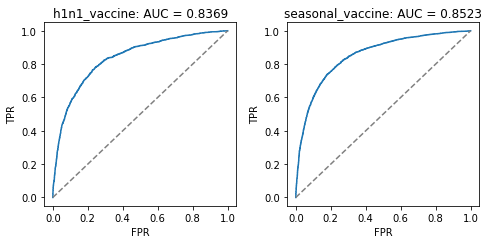

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3.5))

plot_roc(
    y_eval['h1n1_vaccine'], 
    y_preds['h1n1_vaccine'], 
    'h1n1_vaccine',
    ax=ax[0]
)
plot_roc(
    y_eval['seasonal_vaccine'], 
    y_preds['seasonal_vaccine'], 
    'seasonal_vaccine',
    ax=ax[1]
)
fig.tight_layout()

In [23]:
roc_auc_score(y_eval, y_preds)

0.8445813508947102

In [24]:
wandb.log({"auc": roc_auc_score(y_eval, y_preds)})

In [25]:
test_features = pd.read_csv(test_features)
test_features = test_features.set_index("respondent_id")

In [26]:
test_probas = full_pipeline.predict_proba(test_features)

In [27]:
test_probas

[array([[0.9469397 , 0.0530603 ],
        [0.9557425 , 0.0442575 ],
        [0.65003616, 0.34996384],
        ...,
        [0.85434693, 0.14565307],
        [0.93494901, 0.06505099],
        [0.58683196, 0.41316804]]), array([[0.73486857, 0.26513143],
        [0.96108416, 0.03891584],
        [0.4728152 , 0.5271848 ],
        ...,
        [0.79802837, 0.20197163],
        [0.61291707, 0.38708293],
        [0.60632039, 0.39367961]])]

In [28]:
len(test_probas[0])

26708

In [29]:
submission_df = pd.read_csv(submission)
submission_df = submission_df.set_index("respondent_id")

In [30]:
submission_df["h1n1_vaccine"] = test_probas[0][:, 1]
submission_df["seasonal_vaccine"] = test_probas[1][:, 1]

In [31]:
submission_df.head()

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
26707,0.053060,0.265131
26708,0.044257,0.038916
26709,0.349964,0.527185
26710,0.474110,0.880959
26711,0.173590,0.479957


In [32]:
submission_df.to_csv('my_submission.csv', index=True)